In [1]:
import os
import time
from typing import List
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import umap

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem.Crippen import MolLogP


import hdbscan
from transformers import AutoModel
from transformers import AutoTokenizer, AutoModel
import torch

/data/scratch/getzn/miniconda/envs/new_chemberta_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-11 15:16:18.824606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 15:16:18.878476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 15:16:20.659294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

In [18]:
def gen_embeddings(encoded_input, model):
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Average token embeddings
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return token_embeddings, sum_embeddings / sum_mask, model_output[2]

In [5]:
df = pd.read_csv("../data/lipo.csv")

In [122]:
with open('../data/Crippen.txt') as file:
    lines = [line.strip('\n').split('\t') for line in file.readlines() if line[0] != '#' and len(line.strip()) > 0]
crippen_df = pd.DataFrame(lines, columns = ['name', 'smarts', 'logp', 'mr', 'notes']) 
crippen_df = crippen_df[~crippen_df['name'].str.contains('H')]
crippen_df['logp'] = crippen_df['logp'].apply(float)
atom_type_idx_dict = {name: idx for idx, name in enumerate(crippen_df['name'].drop_duplicates().values)}
patterns = {Chem.MolFromSmarts(row['smarts']): atom_type_idx_dict[row['name']] for idx, row in crippen_df.iterrows()}

In [125]:
logps = crippen_df.drop_duplicates(subset='name')['logp'].values

In [126]:
def get_crippen_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    crippen = MolLogP(mol)
    return crippen

In [113]:
df['crippen_logp'] = df['smiles'].apply(get_crippen_logp)

In [114]:
def get_crippen_atom_types(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atom_types = [-1] * mol.GetNumAtoms()
    matches = []
    for pattern, type_idx in patterns.items():
        for match in mol.GetSubstructMatches(pattern, False, False):
            if atom_types[match[0]] != -1:
                matches.append(match)
                atom_types[match[0]] = type_idx
        if None not in atom_types:
            break
    # for match in matches:
        # print(crippen_df['name'].values[np.array(atom_types)[list(match)]])
    return torch.tensor(atom_types)

In [127]:
def get_crippen_atom_types(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atom_types = [None] * mol.GetNumAtoms()
    atom_env_pairs = []
    for pattern, type_idx in patterns.items():
        for match in mol.GetSubstructMatches(pattern, False, False):
            if atom_types[match[0]] is None:
                atom_types[match[0]] = type_idx
                if len(match) > 1:
                    atom_env_pairs.extend([[ref, match[0]] for ref in match[1:]])
                    # atom_env_pairs.extend([[match[0], ref] for ref in match[1:]])
                    # atom_env_pairs.append([match[0], match[0]])
        if None not in atom_types:
            break
    return torch.tensor(atom_types), torch.tensor(atom_env_pairs)

In [128]:
def get_token_atom_idxs(encoded):
    num_atoms = 0
    token_atom_idxs = []
    atom_token_idxs = []
    for token_idx, token in enumerate(encoded.tokens):
        # if token[0] == '<' and token[-1] == '>':
        if token in {'[CLS]', '[SEP]', '[PAD]', '[UNK]'} or len(re.findall(r"(Cl?|Br?|[NOSPFIbcnosp*]|\[[^]]+\])", token)) == 0:
            token_atom_idxs.append(-1)
            continue
        if len(re.findall(r"(Cl?|Br?|[NOSPFIbcnosp*]|\[[^]]+\])", token)) > 1:
            raise ValueError
        token_atom_idxs.append(num_atoms)
        atom_token_idxs.append(token_idx)
        num_atoms += 1
    return torch.tensor(token_atom_idxs), torch.tensor(atom_token_idxs)

In [117]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")

In [14]:
encoded = tokenizer(
    df['smiles'].values.tolist(),
    add_special_tokens=True,
    truncation=True,
    max_length=512,
    padding=True,
    return_tensors='pt'
)

In [16]:
model_uniform = AutoModel.from_pretrained('/data/scratch/getzn/nlp_project/bert-loves-chemistry/chemberta/saved_models/final_train_zinc_100k_uniform_eval_lipo/final', output_attentions=True)
model_matched = AutoModel.from_pretrained('/data/scratch/getzn/nlp_project/bert-loves-chemistry/chemberta/saved_models/final_train_zinc_100k_crippen_matched_50_bins_eval_lipo/final', output_attentions=True)
model_balanced = AutoModel.from_pretrained('/data/scratch/getzn/nlp_project/bert-loves-chemistry/chemberta/saved_models/final_train_zinc_100k_crippen_balanced_50_bins_eval_lipo/final', output_attentions=True)

Some weights of RobertaModel were not initialized from the model checkpoint at /data/scratch/getzn/nlp_project/bert-loves-chemistry/chemberta/saved_models/final_train_zinc_100k_uniform_eval_lipo/final and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /data/scratch/getzn/nlp_project/bert-loves-chemistry/chemberta/saved_models/final_train_zinc_100k_crippen_matched_50_bins_eval_lipo/final and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at /data/scratch/getzn/nlp_project/bert-loves-chemistry/chemberta/saved_models/final_train_zinc_100k_crippen

In [20]:
token_embed_uniform, embed_uniform, att_uniform = gen_embeddings(encoded, model_uniform)
token_embed_matched, embed_matched, att_matched = gen_embeddings(encoded, model_matched)
token_embed_balanced, embed_balanced, att_balanced = gen_embeddings(encoded, model_balanced)

In [190]:
labels = all_token_type_idxs.flatten()
mask = labels != 66
labels = labels[mask]

In [191]:
token_embed_uniform = token_embed_uniform.flatten(end_dim=1)[mask]
token_embed_matched = token_embed_matched.flatten(end_dim=1)[mask]
token_embed_balanced = token_embed_balanced.flatten(end_dim=1)[mask]

In [134]:
all_token_type_idxs = []
all_token_env_pairs = []
for mol_idx in range(len(df)):
    try:
        token_atom_idxs, atom_token_idxs = get_token_atom_idxs(encoded[mol_idx])
        atom_type_idxs, atom_env_pairs = get_crippen_atom_types(df['smiles'][mol_idx])
        token_env_pairs = atom_token_idxs[atom_env_pairs]    
        token_env_pairs[:, 0] += 207 * mol_idx
        token_type_idxs = torch.cat((atom_type_idxs, torch.tensor([66])))[token_atom_idxs]
        all_token_type_idxs.append(token_type_idxs)
        all_token_env_pairs.append(token_env_pairs)
    except:
        import pdb; pdb.set_trace()
all_token_type_idxs = torch.stack(all_token_type_idxs)
all_token_env_pairs = torch.cat(all_token_env_pairs)

In [212]:
def get_attention_type_map(att_head, encoded_atom_types):
    intermediate = torch.scatter_reduce(
        torch.zeros(4200, 207, 67),
        2, 
        encoded_atom_types.unsqueeze(1).expand(4200, 207, 207),
        att_head,
        'sum', 
    )
    final = torch.scatter_reduce(
        torch.zeros(67, 67),
        0, 
        encoded_atom_types.flatten(end_dim=1).unsqueeze(1).expand(869400, 67),
        intermediate.flatten(end_dim=1),
        'mean', 
    )
    return final[:-1, :-1]

In [213]:
att_maps_balanced = torch.stack([
    torch.stack([
        get_attention_type_map(att_balanced[layer_idx][:, head_idx], all_token_type_idxs)
         for head_idx in range(3)
    ])
    for layer_idx in range(3)
])

In [214]:
att_maps_matched = torch.stack([
    torch.stack([
        get_attention_type_map(att_matched[layer_idx][:, head_idx], all_token_type_idxs)
         for head_idx in range(3)
    ])
    for layer_idx in range(3)
])

In [215]:
att_maps_uniform = torch.stack([
    torch.stack([
        get_attention_type_map(att_uniform[layer_idx][:, head_idx], all_token_type_idxs)
         for head_idx in range(3)
    ])
    for layer_idx in range(3)
])

In [238]:
diffs = att_maps_balanced.mean(axis=(0,1)) - att_maps_uniform.mean(axis=(0,1))

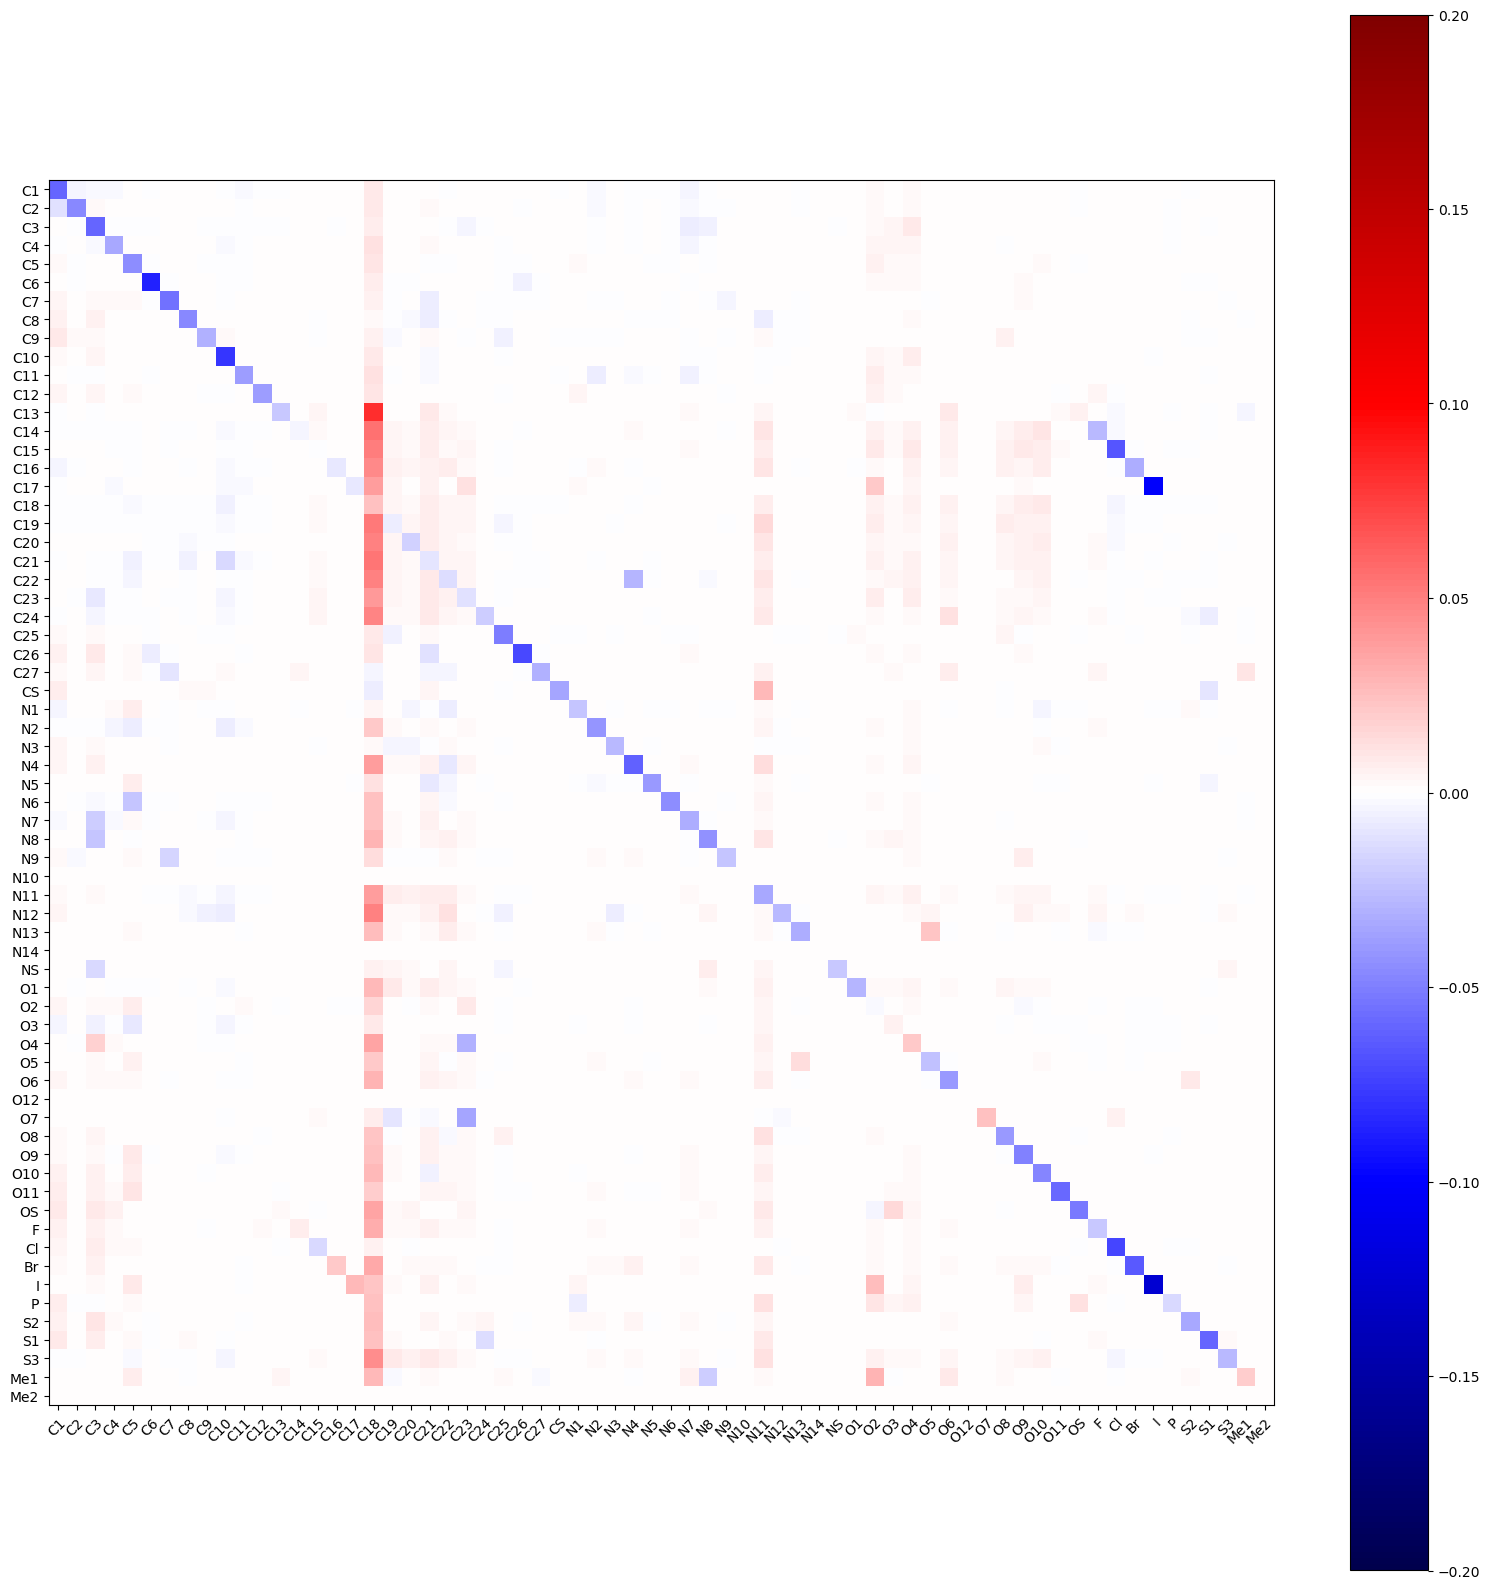

In [239]:
fig, ax = plt.subplots(figsize=(16, 16))
heatmap = ax.imshow(diffs, cmap='seismic', vmin=-0.2, vmax=0.2)
ax.set_xticks(np.arange(66), labels=list(atom_type_idx_dict.keys()))
ax.set_yticks(np.arange(66), labels=list(atom_type_idx_dict.keys()))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(heatmap, orientation='vertical')
fig.tight_layout()